## Prepare data in Colab enviornment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir data
! mkdir data/tid2013
! cp -r drive/MyDrive/Colab\ Notebooks/img-quality-assesment/data/tid2013/distorted_images ./data/tid2013/
! cp drive/MyDrive/Colab\ Notebooks/img-quality-assesment/data/tid2013/mos_with_names.txt ./data/tid2013/
! cp -r drive/MyDrive/Colab\ Notebooks/img-quality-assesment/nima .

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/tid2013’: File exists


#### Install libraries

In [1]:
! pip install livelossplot

In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.keras as keras

# Start : In local docker only
import sys
sys.path.append('/home/jovyan/work') 
# End : In local docker only

import nima as nima

### Load Dataset

In [17]:
from nima.utils.tid_dataset_utils import load_tid_data
from nima.config import DATASET_DIR
from nima.utils.ava_downloader import print_msg

p_dataset_dir = DATASET_DIR
p_model_name = 'vgg'
p_batch_size = 64
p_epochs = 10
p_sample_size=100
p_metrics = ['accuracy']
p_verbose = 1

tid_dataset_dir = os.path.join(p_dataset_dir, 'tid2013')
tid_images_dir = os.path.join(tid_dataset_dir, 'distorted_images')
img_format = 'bmp'
print_msg(f'Images directory {tid_images_dir}')

# Load the dataset
x_col, y_cols = 'image_id', 'rating'
df_train, df_valid, df_test = load_tid_data(tid_dataset_dir, p_sample_size)
assert len(df_train) > 0 and len(df_valid) > 0 and len(df_test) > 0, 'Empty dataframe'
train_batch_size = valid_batch_size = p_batch_size
test_batch_size = min(p_batch_size, 32, len(df_test))

df_train.head()

Images directory /home/jovyan/work/data/tid2013/distorted_images
Number of samples picked 100


,rating,image_id
0,3.70588,i25_06_3
1,3.20513,i17_07_4
2,4.92857,i18_07_2
3,5.11111,i11_19_2
4,4.19444,i02_01_4


In [7]:
df_train.describe()

,rating
count,72.000000
mean,4.510423
std,1.499218
min,0.421050
25%,3.525272
50%,4.675340
75%,5.725223
max,7.100000


### Create the model

In [12]:
from nima.model.model_builder import NIMA
from nima.config import INPUT_SHAPE
from tensorflow.keras.losses import mean_squared_error

# Form the NIMA Aesthetic Model
nima_technical_cnn = NIMA(base_model_name=p_model_name, weights='imagenet', model_type='aesthetic',
                            input_shape=INPUT_SHAPE, metrics=p_metrics)

# Build the model for training
nima_technical_cnn.build()
nima_technical_cnn.compile(train_layers=False)
nima_technical_cnn.model.summary()

Model's module - tensorflow.keras.applications.vgg19.VGG19
Model compiled successfully.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________

### Create Model

In [13]:
# Get the generator
train_generator = NimaDataGenerator(df_train, tid_images_dir, x_col, y_cols, img_format=img_format, num_classes=1,
                                    preprocess_input=nima_technical_cnn.preprocessing_function(),
                                    is_train=True, batch_size=train_batch_size, )
valid_generator = NimaDataGenerator(df_valid, tid_images_dir, x_col, y_cols, img_format=img_format, num_classes=1,
                                    preprocess_input=nima_technical_cnn.preprocessing_function(),
                                    is_train=True, batch_size=valid_batch_size, )


Found 72 valid image filenames belonging to 1 classes.
Found 18 valid image filenames belonging to 1 classes.


##### Train the model

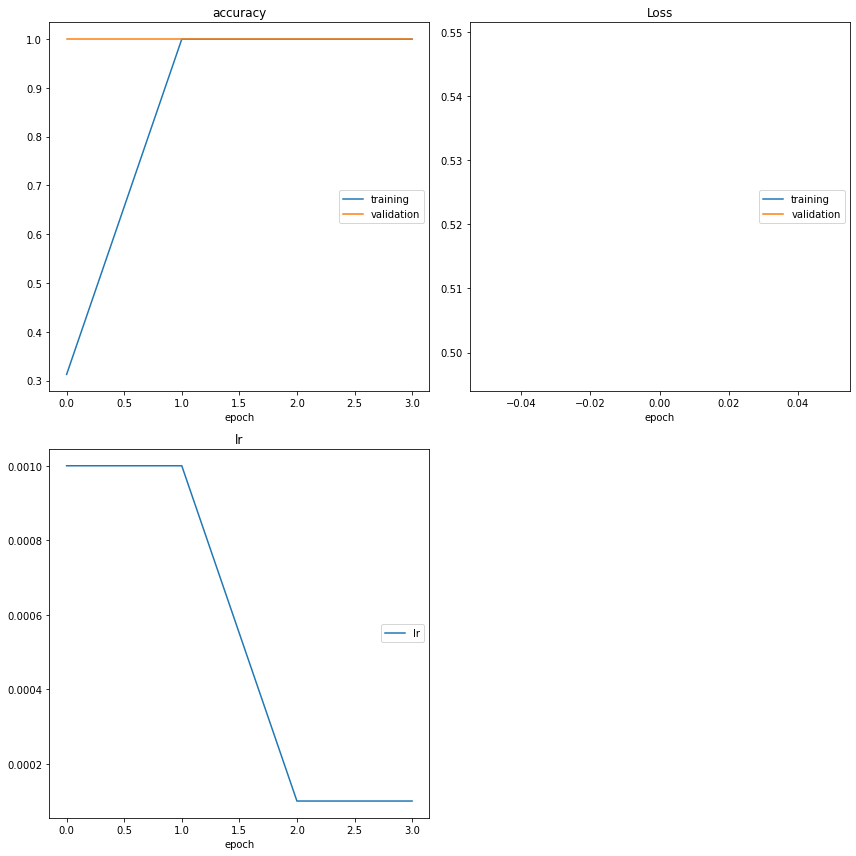

Epoch 00004: early stopping
Training Time (HH:MM:SS) : 00:06:03


In [18]:
from nima.model.data_generator import NimaDataGenerator

train_result_df, train_weights_file = nima_technical_cnn.train_model(train_generator, valid_generator,
                                                                     epochs=p_epochs, verbose=p_verbose)

#### Test the model

In [19]:
print_msg(f'Testing Batch size {test_batch_size}', 1)
test_generator = NimaDataGenerator(df_test, tid_images_dir, x_col, y_col=None,
                                   img_format=img_format, num_classes=1,
                                   preprocess_input=nima_technical_cnn.preprocessing_function(),
                                   is_train=False, batch_size=test_batch_size)

test_steps = np.ceil(len(test_generator) / test_batch_size)
predictions = nima_technical_cnn.model.predict(test_generator, steps=test_steps)


Found 10 valid image filenames belonging to 1 classes.


In [21]:
predictions.shape

(10, 10)

#### Test the model for one image

<class 'PIL.BmpImagePlugin.BmpImageFile'>


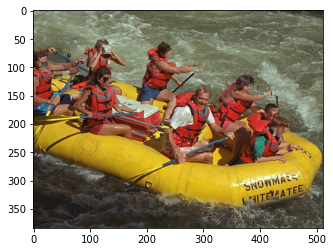

In [35]:
from nima.utils import image_utils
import matplotlib.pyplot as plt

image = df_test.iloc[0]['image_id']
y_true = df_test.iloc[0]['rating']

# Form image path
image = os.path.join(tid_images_dir, f'{image}.bmp')
# convert to numpy array
image_np = image_utils.load_img(image, INPUT_SHAPE)
# x = (nima_technical_cnn.preprocessing_function())(image_np)
print(type(image_np))
plt.imshow(image_np)

In [ ]:
predict = 